In [2]:
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
import os
import pandas as pd
import time
import json
import pickle
import seaborn as sb
import mpld3

In [17]:
from power_planner.data_reader import DataReader

In [18]:
layer_path = "../../data/instance_DE.nosync/tif_layers" # belgium.nosync/tif_layers"
csv_path = "../../data/instance_DE.nosync/layer_weights.csv" # /belgium.nosync/layer_weights.csv"
json_path = "../../outputs/de_new_data" # paths_compare"

### Load the general data

In [19]:
arr, forb, df = DataReader.get_raw_data(layer_path, csv_path)

(3078, 3724)
(3078, 3724)
(3078, 3724)


In [20]:
# make instance that is good to display
disp_inst = np.sum(np.array([arr[i]* df["weights"].values[i] for i in range(len(arr))]), axis=0)
disp_inst = (disp_inst-np.min(disp_inst))/(np.max(disp_inst)-np.min(disp_inst))

In [21]:
disp_inst = np.swapaxes(disp_inst, 1,0)

### Select the paths to analyze

In [195]:
# Load data new
json_names = ["sensitivity_de_I_1422_Wald_ohne_Bedeutung_0_0.csv", "sensitivity_de_I_1422_Wald_ohne_Bedeutung_3_0.csv"]
# ["industrie_50_siedlung_150_de_3.csv", "industrie_50_siedlung_150_de_4.csv"]
# "fast_e5_d70_de_0.csv", "fast_e5_d70_de_1.csv", "fast_e5_d70_de_2.csv","fast_e5_d70_de_3.csv","fast_e5_d70_de_4.csv"]
path_list = []
for csv in json_names:
    path_arr = np.asarray(pd.read_csv(os.path.join(json_path, csv))[["X_raw", "Y_raw"]]).astype(int)
    path_list.append(path_arr)

## Interactive plots

#### Hover to see layers

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(disp_inst)

ax.set_title("Crossed layers", size=20)

for p, path in enumerate(path_list):
    # construct labels: - TODO: merge
    label_list = []
    for (i,j) in path:
        current_labels = []
        for k in range(len(arr)):
            if arr[k, i,j]:
                # label_name = df["layer"].values[k]
                # only for de instance:
                name = df["layer"].values[k]
                label_name = " ".join(name.split("_")[2:])
                current_labels.append(label_name)
        if len(current_labels)>0:
            label_list.append(current_labels) # "\n".join(current_labels))
        else:
            label_list.append(["None"])
    
    # convert to HTML for formatting
    html_placeholder = "<p> <font size='4' color='orange'>{title}</font>"
    labels = []
    for lab in label_list:
        fill_str = [html_placeholder.format(title=l) for l in lab]
        labels.append("".join(fill_str))

    # scatter
    scatter = ax.scatter(path[:,0], path[:,1])

    tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)


# labels = label_list # ['point {0}'.format(i + 1) for i in range(len(test_path))]
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)

mpld3.display()
# mpld3.save_html(fig, "crossed_layers.html")

### Interactive pareto paths

In [215]:
base_path = "../../outputs/de_new_data/pareto"
unique_ids = [f for f in os.listdir(base_path) if f[-3:]=="csv" and f[:2]=="po"]

minima = [1, 2]
maxima = [9, 30]

path_tuple_list = list()
for fn in unique_ids:
    path_table = pd.read_csv(os.path.join(base_path, fn))
    params = (fn.split("sensitivity_")[1]).split("_")[:-1]
    params = [int(a[1:]) for a in params]
    path_tuple_list.append((params, np.asarray(path_table[["X_raw", "Y_raw"]])))

In [243]:
# HYPERPARAMETER: which parameter to analyze: (here: 0=Angle, 1=Edge)
param_ind = 1

#### Group paths

In [244]:
from collections import defaultdict

In [245]:
path_lens = [len(p) for _, p in path_tuple_list]
max_len = max(path_lens)

In [246]:
param_path_dict = defaultdict(list)
for param, path in path_tuple_list:
    param_key = param[param_ind]
    # pad path:
    padded_path = path.tolist() + [path[-1] for _ in range(max_len-len(path))]
    param_path_dict[param_key].append(padded_path)
for key, elem in param_path_dict.items():
    param_path_dict[key] = np.asarray(elem)
param_path_dict = OrderedDict(sorted(param_path_dict.items(), key=lambda item: item[0]))

#### Plot

In [247]:
from collections import OrderedDict


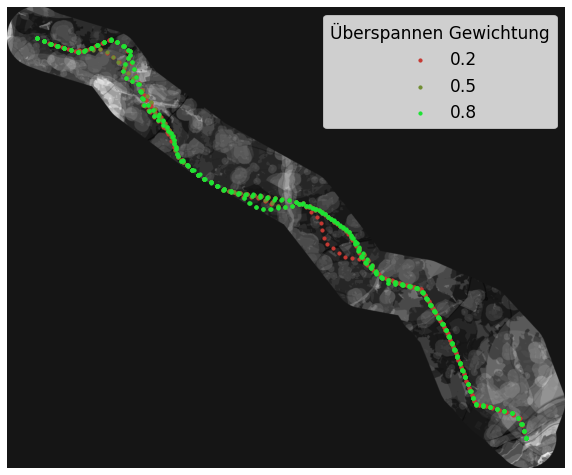

In [260]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(disp_inst)

max_param = 8 # maxima[param_ind]
for param, path_collection in param_path_dict.items():
    col = [1-param/max_param, np.clip(param/max_param, 0,1), 0.2]
    path_collection = np.asarray(path_collection)
    param_lab = 0.1*param
    l = ax.scatter(path_collection[:,:,0].T, path_collection[:,:, 1].T, s=10, label=str(param_lab), color=col) # , lw=2, alpha=0.8)
    # l = ax.plot(path_collection[:,:,0].T, path_collection[:,:, 1].T, '-', label=str(param_lab), color=col, lw=2, alpha=0.8)
    # ax.fill_between(path_collection[:,0], path_collection[:,1]-2, path_collection[:,1]+2, color=col, alpha=.4)
plt.rcParams['legend.title_fontsize'] = 17
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=17, title="Überspannen Gewichtung")
plt.axis("off")
plt.savefig("varying_edge.png")
plt.show()

## Interactive plot

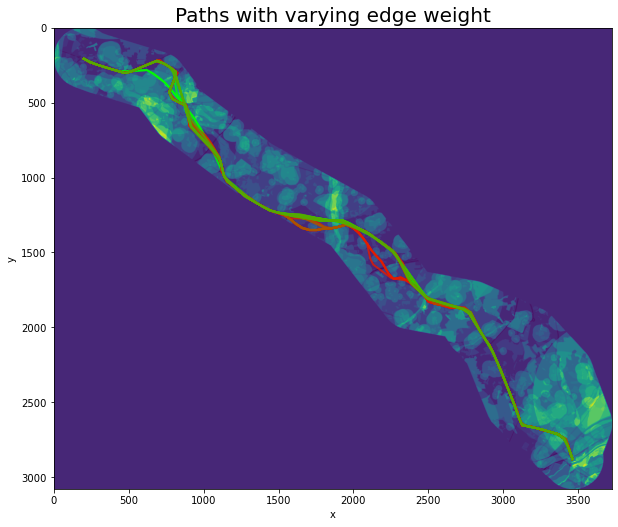

In [202]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(disp_inst)


line_collection, labels = list(), list()
for param, path_collection in param_path_dict.items():
    col = [1-param/maxima[param_ind], param/maxima[param_ind], 0]
    path_collection = np.asarray(path_collection)
    l = ax.plot(path_collection[:,:,0].T, path_collection[:,:, 1].T, '-', label=param, color=col, lw=2, alpha=0.8)
    # ax.fill_between(path_collection[:,0], path_collection[:,1]-2, path_collection[:,1]+2, color=col, alpha=.4)
    line_collection.append(l)
    labels.append(param)

# for params, path in path_tuple_list:
#     col = [1-params[param_ind]/maxima[param_ind], params[param_ind]/maxima[param_ind], 0]
#     l, = ax.plot(path[:,0], path[:,1], '-o', label=params[param_ind], c=col)
#     ax.fill_between(path[:,0], path[:,1]-2, path[:,1]+2, color=col, alpha=.4)

# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# handles, labels = (by_label.values(), by_label.keys())
# print(handles, labels)
# print(ax.collections)
# handles, labels = ax.get_legend_handles_labels() # return lines and labels
interactive_legend = mpld3.plugins.InteractiveLegendPlugin(line_collection,
                                                         labels,
                                                         alpha_unsel=0,
                                                         alpha_over=1.5, 
                                                         start_visible=False)

    
# zip(handles, ax.collections),
mpld3.plugins.connect(fig, interactive_legend)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Paths with varying edge weight', size=20)

# mpld3.display()
mpld3.save_html(fig, "sensitivity angle weight.html")

## How many crossing paths

#### Pool all paths

In [319]:
path_list = []
folders = ["layer_sensitivity",  "optimal_paths", "pareto"]  # "weight_sensitivity_0905", "weight_sensitivity_0905", 
# "sensitivity_tuples", 
prev_len = 0
for path in folders:
    for fn in os.listdir(os.path.join("../../outputs/de_presentation", path)):
        if fn[-3:]=="csv":
            path_table = pd.read_csv(os.path.join("../../outputs/de_presentation", path, fn))
            path_list.append((np.asarray(path_table[["X_raw", "Y_raw"]])))
    print(path, len(path_list)-prev_len)
    prev_len = len(path_list)

layer_sensitivity 37
optimal_paths 10
pareto 24


In [320]:
from power_planner.utils.utils import bresenham_line

In [321]:
buffer = 8 # 4
line_buffer = 4 # 2
x_len, y_len = disp_inst.shape
mark_array = np.zeros((y_len, x_len))
for path in path_list: # path_tuple_list
    path = np.asarray(path).astype(int)
    for p in range(len(path)):
        (i,j) = path[p]
        mark_array[i:i+buffer+1, j:j+buffer+1] = mark_array[i:i+buffer+1, j:j+buffer+1] + 1
        if p<len(path)-1:
            (k,l) = path[p+1]
            line_points = bresenham_line(i,j,k,l)
            for (x,y) in line_points[1:-1]:
                mark_array[x:x+line_buffer, y:y+line_buffer] = mark_array[x:x+line_buffer, y:y+line_buffer] + 1

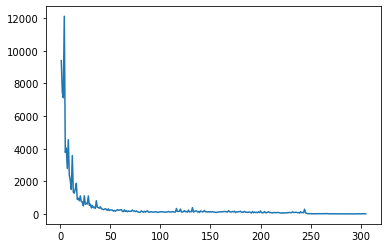

In [315]:
# mark_array = np.log(mark_array)
uni, counts = np.unique(mark_array, return_counts=True)
plt.plot(uni[1:], counts[1:])

# small values appear very often --> most cells are not crossed many times

In [324]:
grey_disp_inst = np.tile(np.expand_dims(disp_inst,2),3)
x_nonzero, y_nonzero = np.where(mark_array>0)
max_val = np.max(mark_array)
for (x, y) in zip(x_nonzero, y_nonzero):
    normed = mark_array[x,y] / (max_val-150)
    grey_disp_inst[y,x] = [np.clip(1-normed, 0,1), np.clip(normed+0.4, 0,1), 0.2]

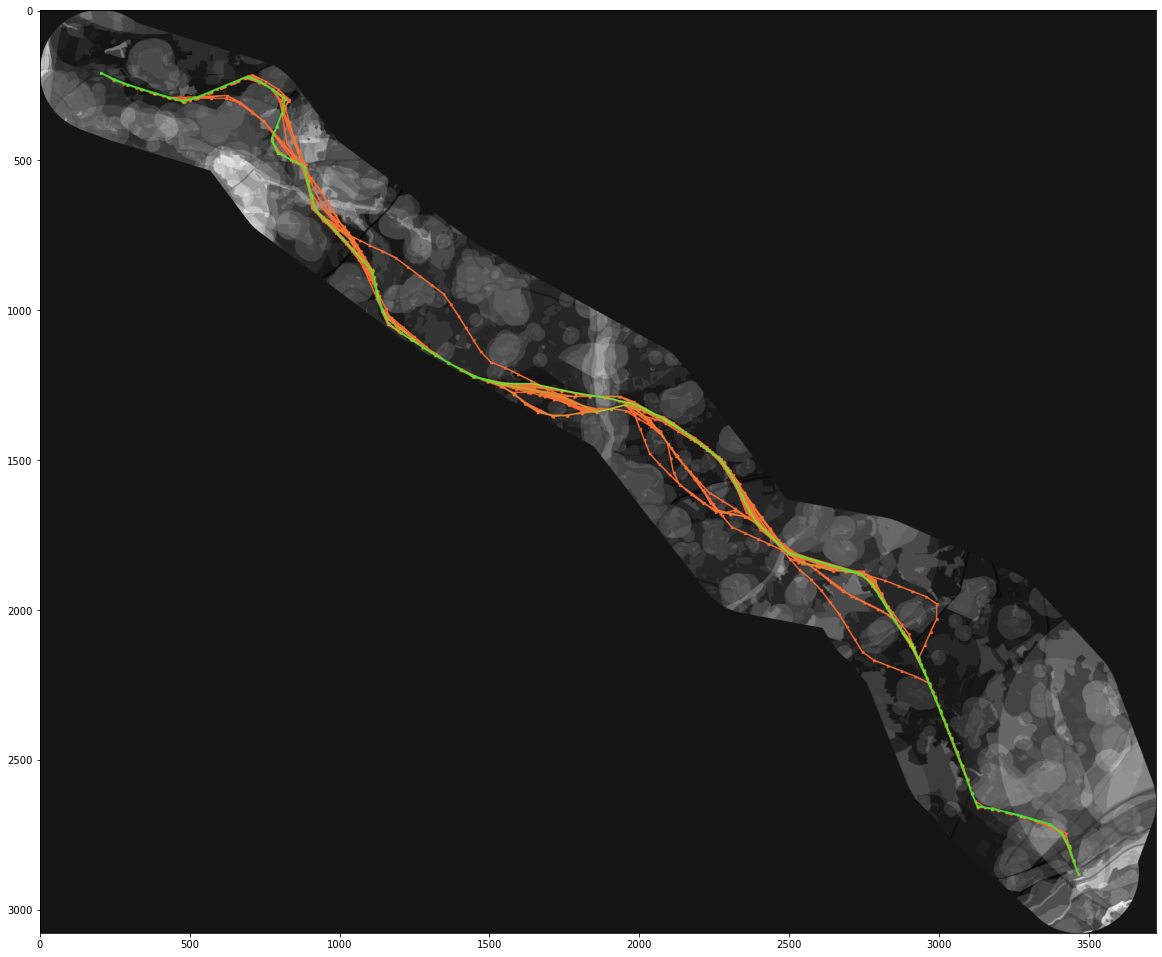

In [325]:
plt.figure(figsize=(20,20))
plt.imshow(grey_disp_inst)
plt.savefig("layer_sensitivity_pareto.png")
plt.show()

In [318]:
len(path_list)

61

### Ideen

* auch die KSP csvs dazu nehmen?
* interactive --> drüber hovern und man sieht, wie die csv files heißen, die diesen Punkt erzeugen? Dann wäre es aber normaler Scatter

## Layer-wise sensitivity analysis

In [202]:
from power_planner.utils.utils_ksp import KspUtils

In [203]:
base = "../../outputs/de_presentation/sensitivity_tuples" # layer_sensitivity"
csvs = os.listdir(base)
csvs = sorted(csvs)

In [204]:
baseline_path = np.asarray(pd.read_csv(os.path.join(base, "../layer_sensitivity", "sensitivity_debaseline.csv"))[["X_raw", "Y_raw"]]).astype(int)


In [205]:
path_list = []
for csv in csvs:
    path_arr = np.asarray(pd.read_csv(os.path.join(base, csv))[["X_raw", "Y_raw"]]).astype(int)
    path_list.append(path_arr)
    # print(KspUtils.path_distance(path_arr, baseline_path, mode="jaccard"))

#### compare different weights at one layer

['sensitivity_de_I_1111_Wohnumfeldschutz_0.csv', 'sensitivity_de_I_1111_Wohnumfeldschutz_1.csv', 'sensitivity_de_I_1111_Wohnumfeldschutz_2.csv']
True
False
False


<ipython-input-255-fafc55325e0a>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.all(path1==path))


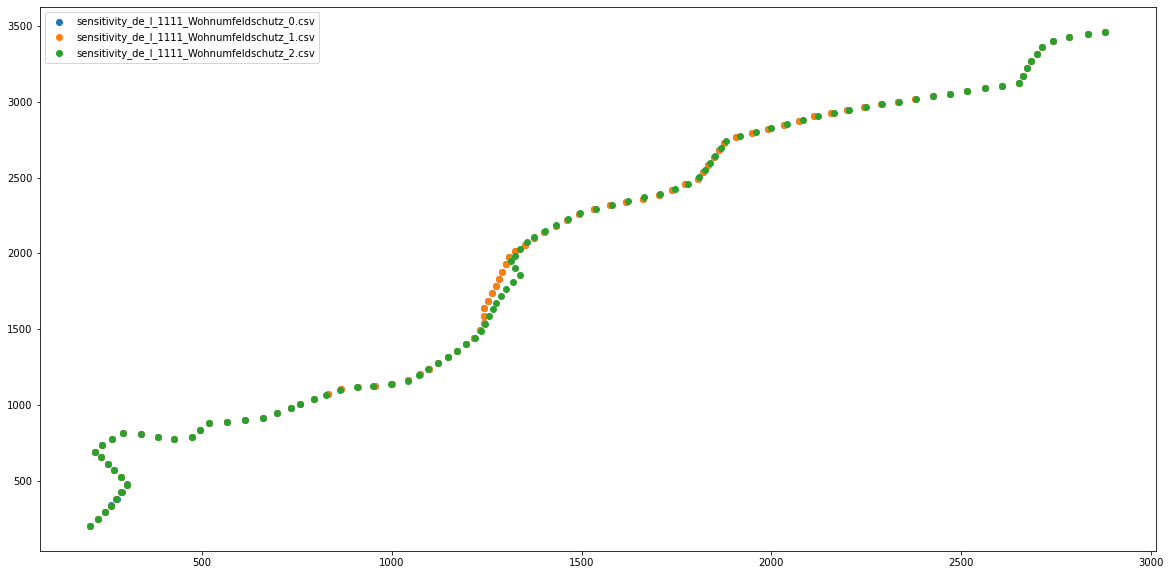

['sensitivity_de_I_1311_Landschaftl_Vorbehaltsgebiet_0.csv', 'sensitivity_de_I_1311_Landschaftl_Vorbehaltsgebiet_1.csv', 'sensitivity_de_I_1311_Landschaftl_Vorbehaltsgebiet_3.csv']
True
True
False


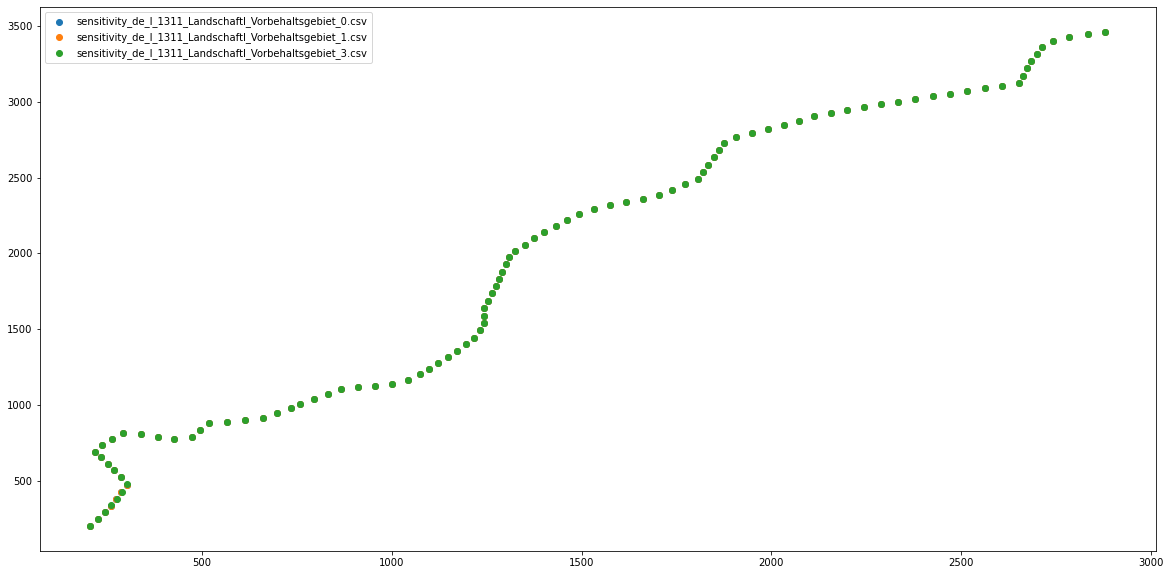

['sensitivity_de_I_1421_Bannwald_0.csv', 'sensitivity_de_I_1421_Bannwald_1.csv', 'sensitivity_de_I_1421_Bannwald_2.csv']
True
False
False


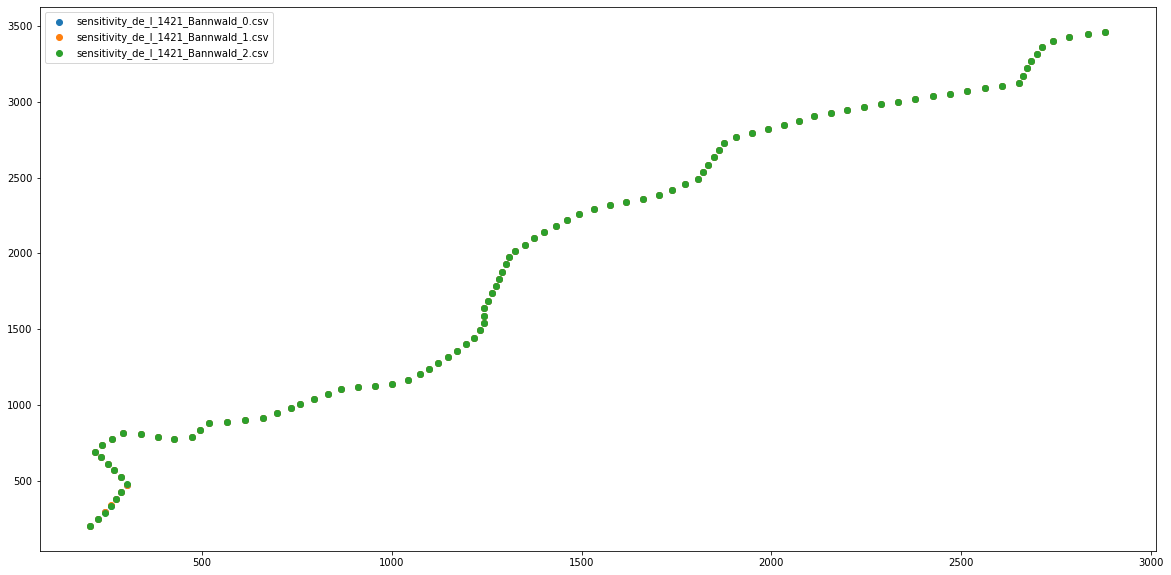

['sensitivity_de_I_1422_Wald_ohne_Bedeutung_0.csv', 'sensitivity_de_I_1422_Wald_ohne_Bedeutung_1.csv', 'sensitivity_de_I_1422_Wald_ohne_Bedeutung_3.csv']
True
False
False


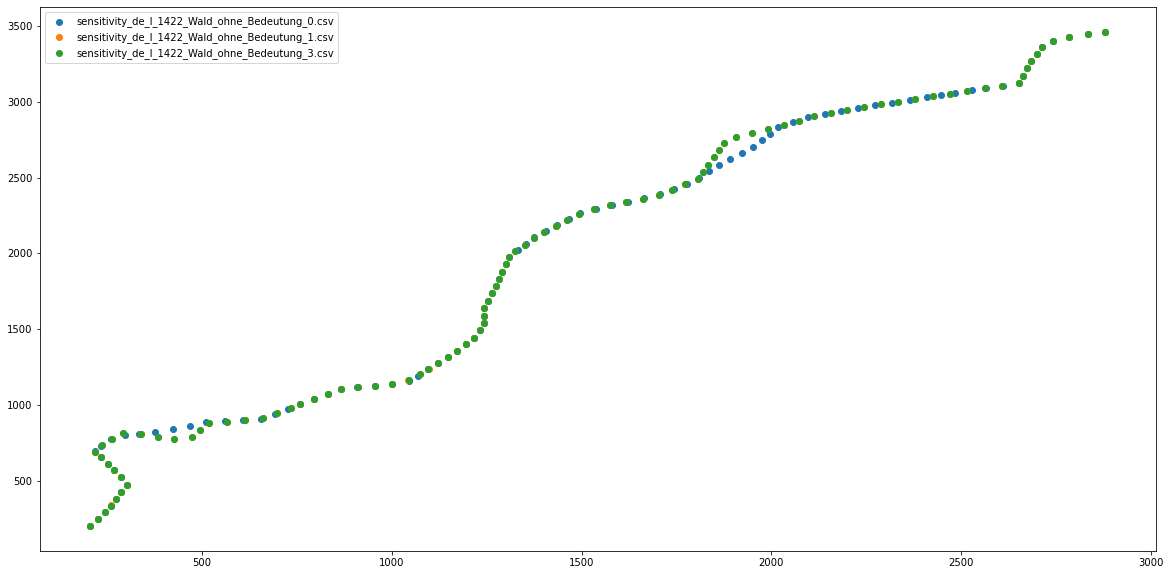

['sensitivity_de_I_1812_Strassen_ueberregional.tif_-2.csv', 'sensitivity_de_I_1812_Strassen_ueberregional.tif_-3.csv', 'sensitivity_de_I_1812_Strassen_ueberregional.tif_0.csv']
True
False
False


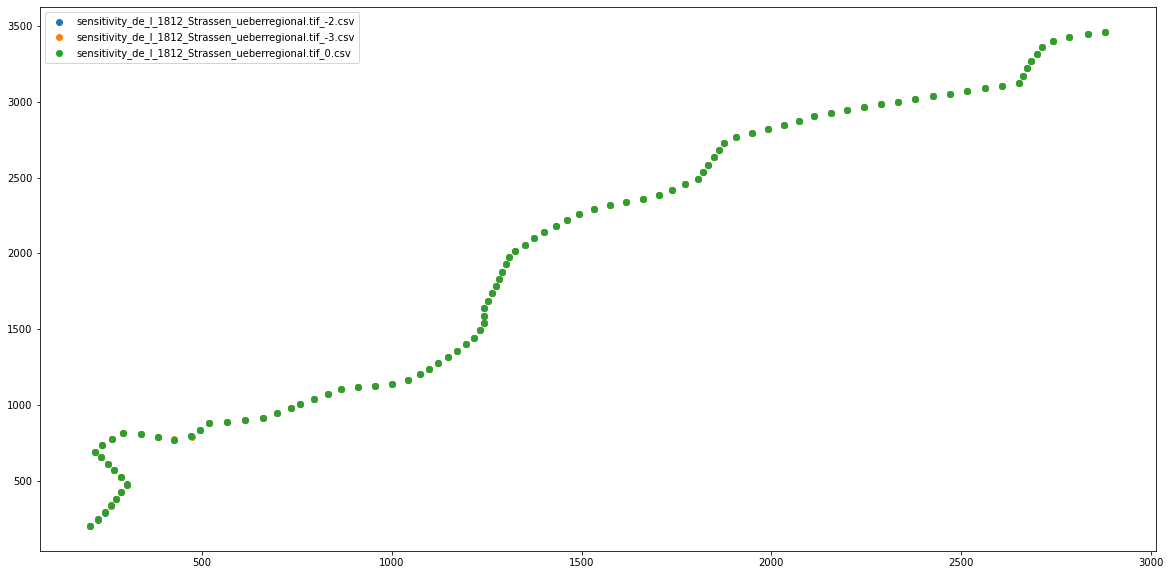

['sensitivity_de_I_2214_VS_5000m_0.csv', 'sensitivity_de_I_2214_VS_5000m_1.csv', 'sensitivity_de_I_2214_VS_5000m_3.csv']
True
True
False


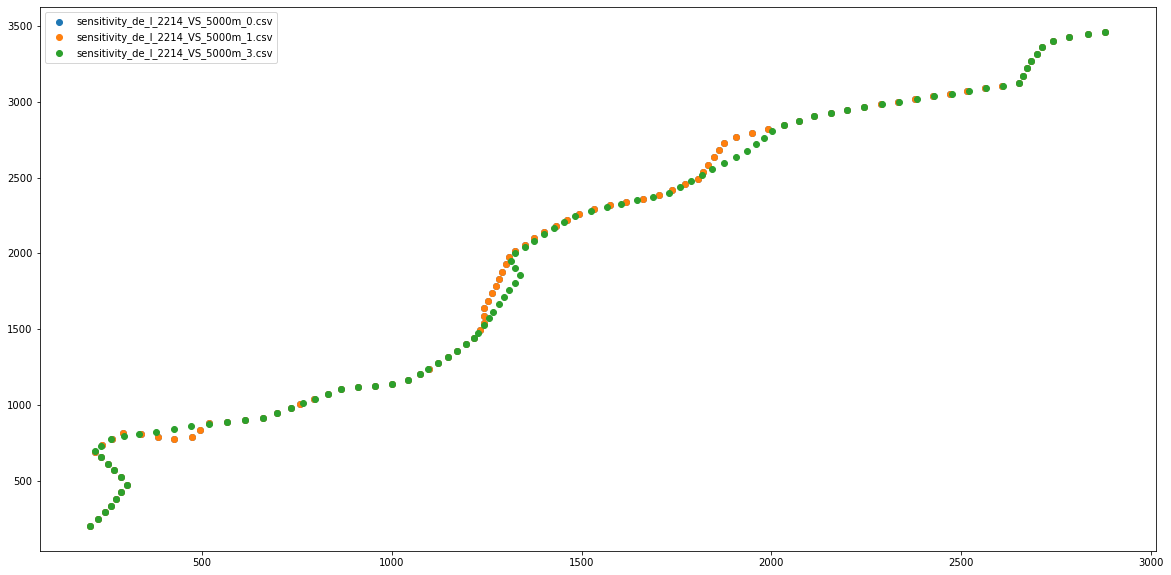

['sensitivity_de_I_2224_Gesetzl_geschuetzte_Biotope_0.csv', 'sensitivity_de_I_2224_Gesetzl_geschuetzte_Biotope_1.csv', 'sensitivity_de_I_2224_Gesetzl_geschuetzte_Biotope_3.csv']
True
False
False


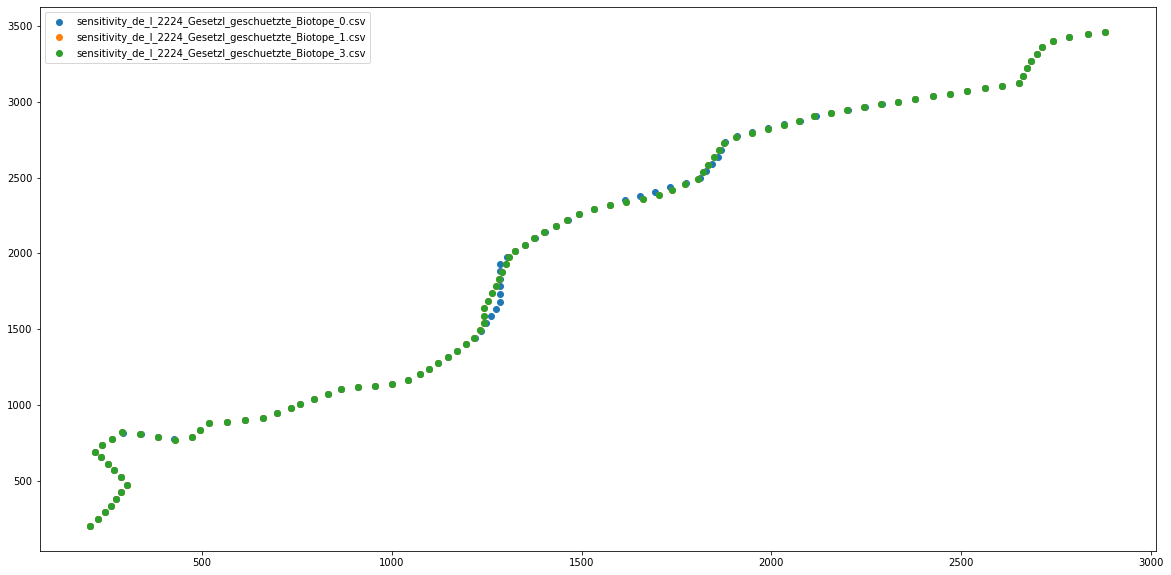

['sensitivity_de_I_2511_Wald_Bedeutung_Klimaschutz_0.csv', 'sensitivity_de_I_2511_Wald_Bedeutung_Klimaschutz_1.csv', 'sensitivity_de_I_2511_Wald_Bedeutung_Klimaschutz_3.csv']
True
False
False


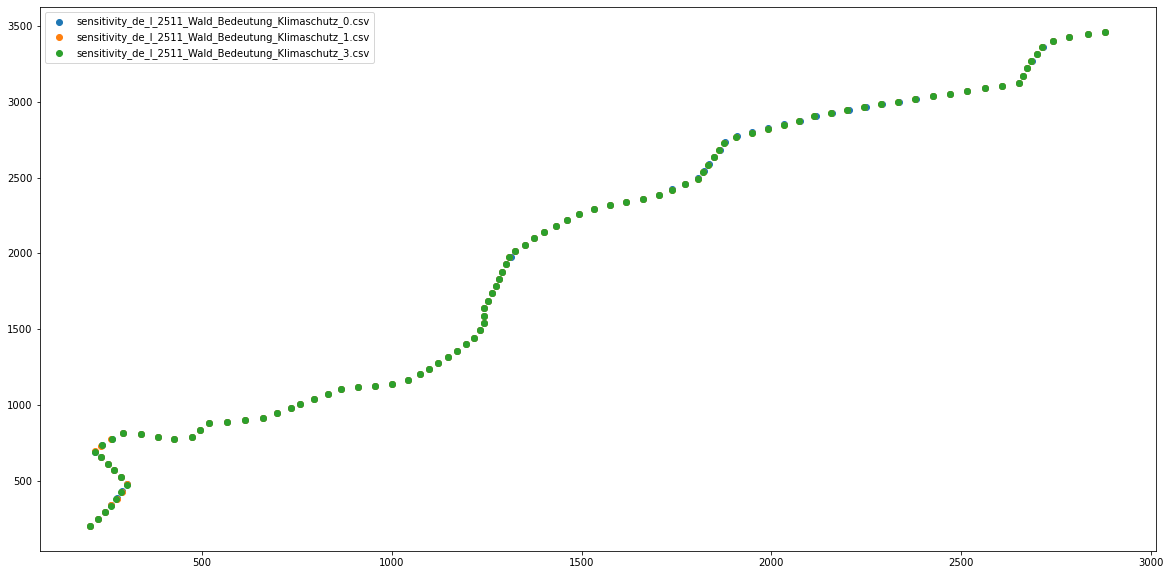

['sensitivity_de_I_2611_Landschaftsbildeinheit_sehr_und_hohe_Bedeutung_0.csv', 'sensitivity_de_I_2611_Landschaftsbildeinheit_sehr_und_hohe_Bedeutung_1.csv', 'sensitivity_de_I_2611_Landschaftsbildeinheit_sehr_und_hohe_Bedeutung_3.csv']
True
False
False


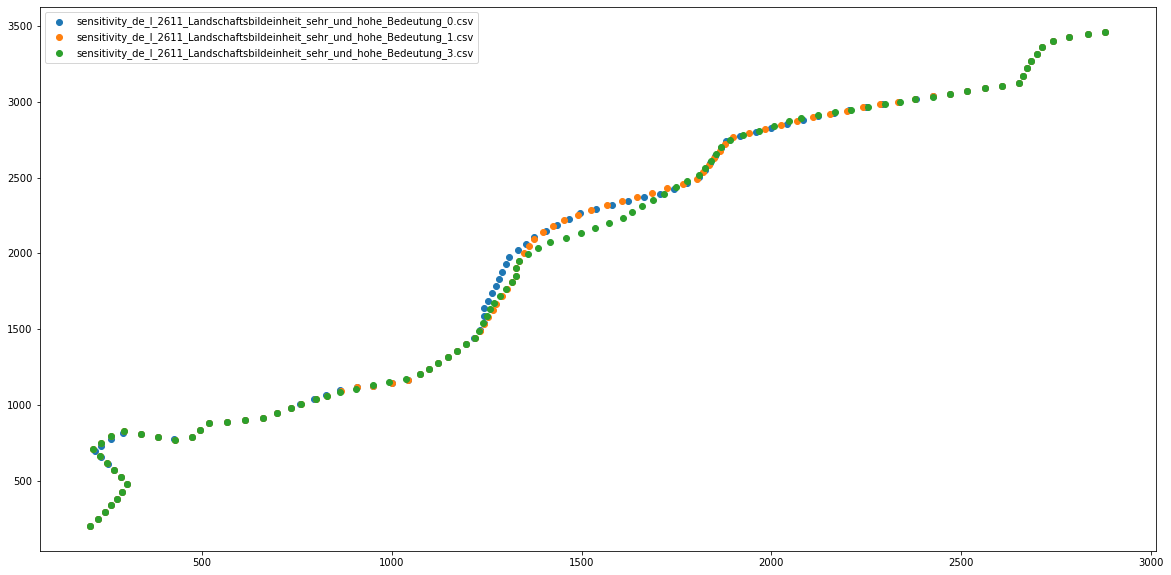

['sensitivity_de_I_2711_Bodendenkmaeler_0.csv', 'sensitivity_de_I_2711_Bodendenkmaeler_2.csv', 'sensitivity_de_I_2711_Bodendenkmaeler_3.csv']
True
False
False


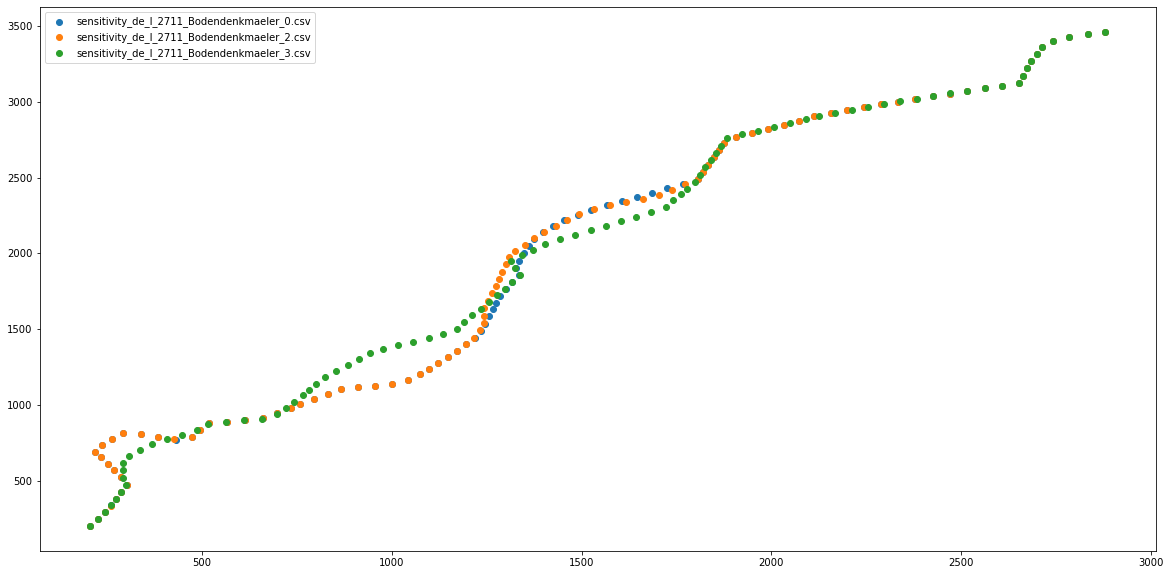

['sensitivity_de_I_2713_Landschaftspraegende_Denkmaeler_inkl_3000m_0.csv', 'sensitivity_de_I_2713_Landschaftspraegende_Denkmaeler_inkl_3000m_1.csv', 'sensitivity_de_I_2713_Landschaftspraegende_Denkmaeler_inkl_3000m_3.csv']
True
False
True


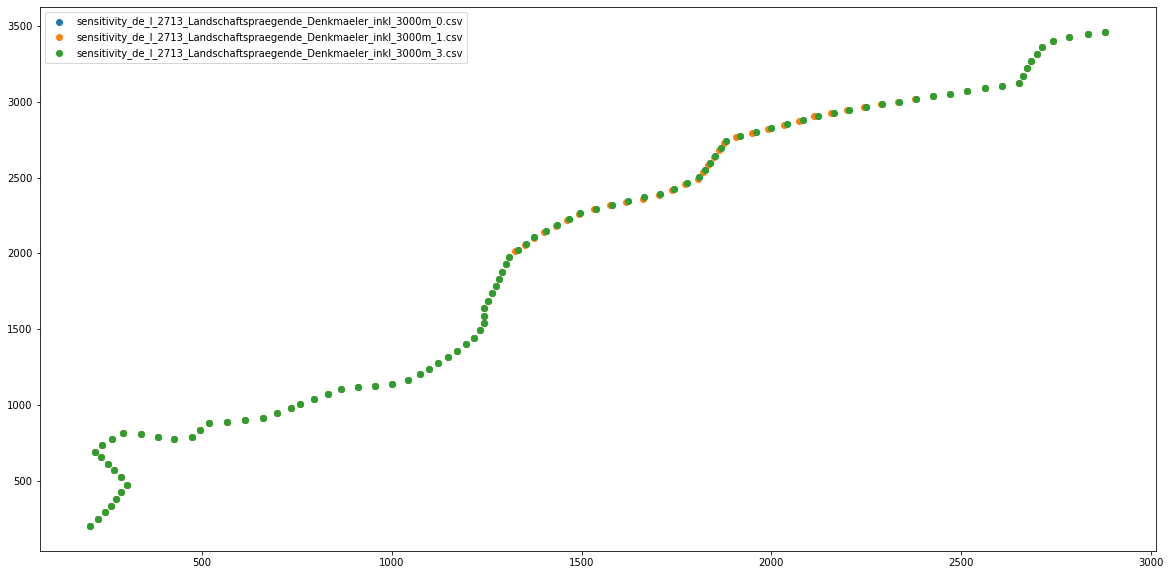

['sensitivity_de_TA_Laerm_Grenzwerte_0.csv', 'sensitivity_de_TA_Laerm_Grenzwerte_1.csv', 'sensitivity_de_TA_Laerm_Grenzwerte_2.csv']
True
True
True


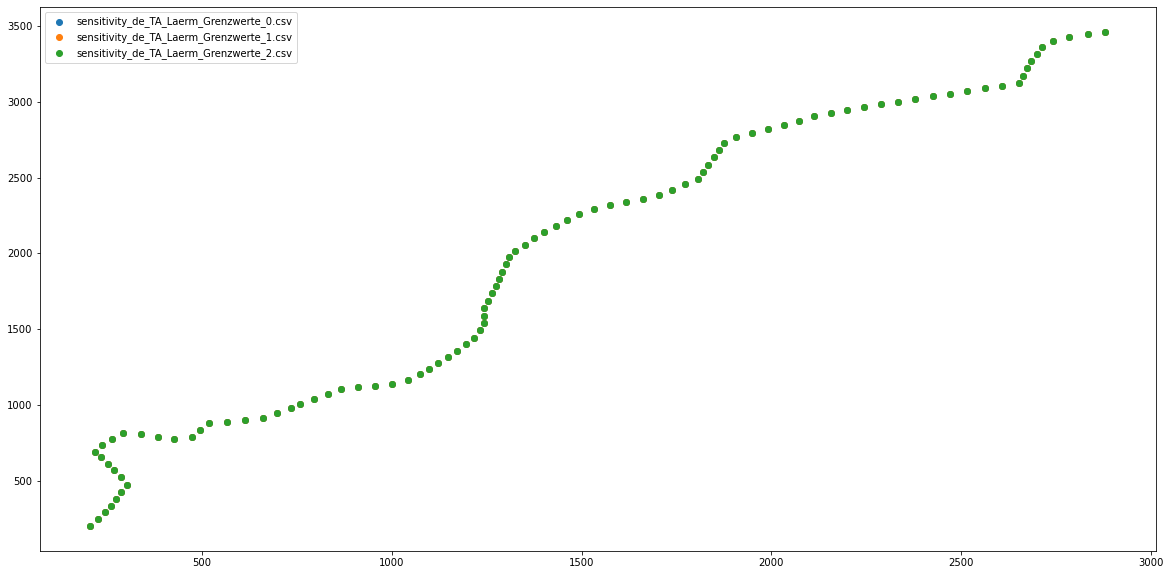

In [255]:
for j in range(int(len(path_list)/3)):
    print(csvs[j*3:(j+1)*3])
    one_layer = path_list[j*3:(j+1)*3]
    one_layer_name = csvs[j*3:(j+1)*3]
    path1 = one_layer[0]
    plt.figure(figsize=(20,10))
    for path, name in zip(one_layer, one_layer_name):
        print(np.all(path1==path))
        plt.scatter(path[:,1], path[:,0], label=name)
    plt.legend()
    plt.show()

#### Plot all and check unique ones

<ipython-input-206-4c52aa286061>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  comp_already = [np.all(uni==path) for uni in unique_paths]
<ipython-input-206-4c52aa286061>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  comp_already = [np.all(uni==path) for uni in unique_paths]
<ipython-input-206-4c52aa286061>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  comp_already = [np.all(uni==path) for uni in unique_paths]
<ipython-input-206-4c52aa286061>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  comp_already = [np.all(uni==path) for uni in unique_paths]
<ipython-input-206-4c52aa286061>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  comp_already = [np.all(uni==path) for uni in unique_paths]
<ipython-input-206-4c52aa286061>:6: DeprecationWarning: elem

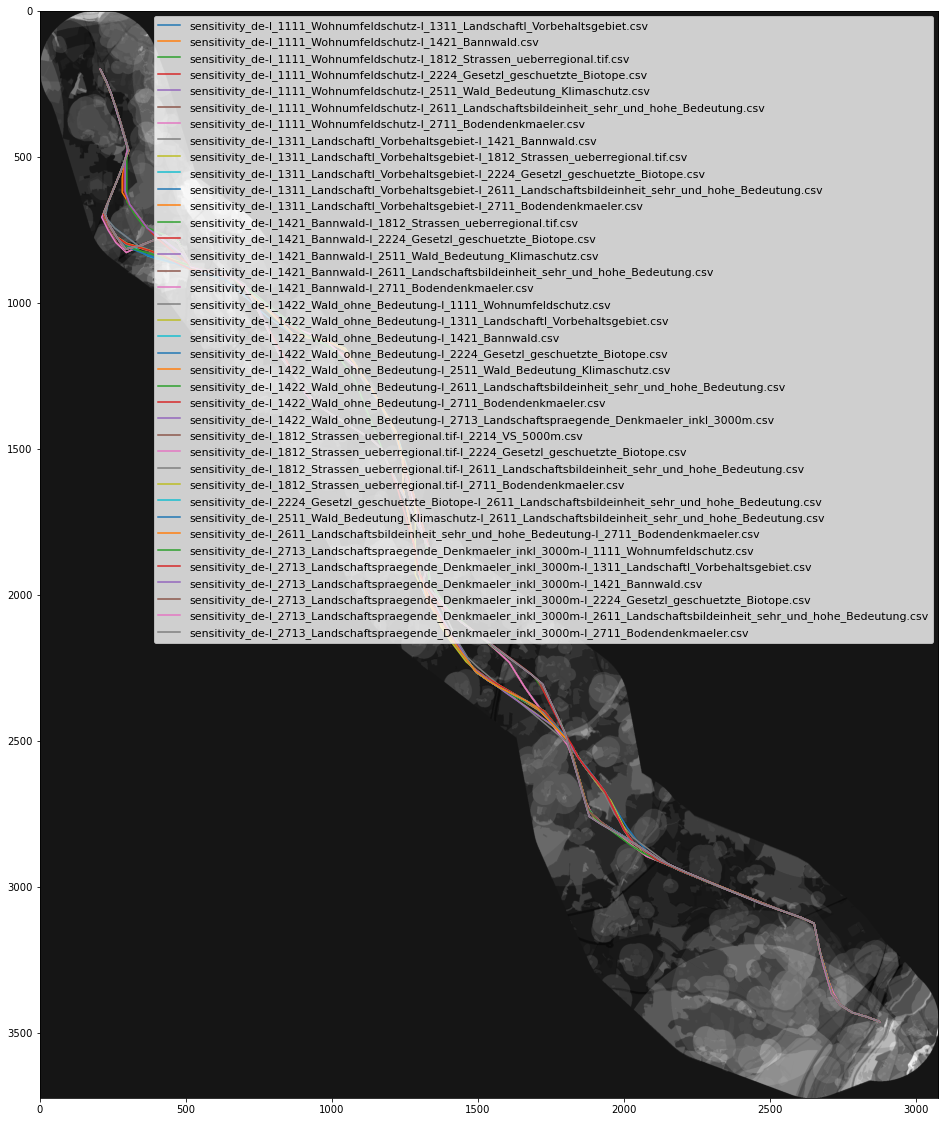

number of unique paths 39 vs overall 67


In [206]:
unique_paths = [baseline_path]
plt.figure(figsize=(20,20))
plt.imshow(np.swapaxes(disp_inst, 1,0))
for j, path in enumerate(path_list):
    # if csvs[j][-5]=="0":
    comp_already = [np.all(uni==path) for uni in unique_paths]
    if not np.any(comp_already):
        unique_paths.append(path)
        plt.plot(path[:,1], path[:,0], label=csvs[j])
plt.legend(fontsize=11)
#plt.savefig("../../figure/de_layer_sensitivity.png")
plt.show()
print("number of unique paths", len(unique_paths), "vs overall", len(csvs))

#### Compute distances to baseline

In [208]:
dists = list()
resolution = 20
for path, name in zip(path_list, csvs):
    max_eucl = (
        KspUtils.path_distance(path, baseline_path, mode="eucl_max") * resolution
    )
    mean_eucl = (
        KspUtils.path_distance(path, baseline_path, mode="eucl_mean") * resolution
    )
    jaccard = 1 - (
        KspUtils.path_distance(path, baseline_path, mode="jaccard")
    )
    # print(name, max_eucl)
    dists.append([round(max_eucl,2), round(mean_eucl,2), round(jaccard, 2)])
dists = np.array(dists)
df = pd.DataFrame(dists, columns=["Maximum distance (in m)", "Mean distance (in m)", "IoU"], index=csvs)

In [209]:
df.to_csv("../../outputs/de_presentation/layer_sensitivity_tuples.csv") # [df["Maximum distance (in m)"]>7*resolution]

####  plot the weggelassene

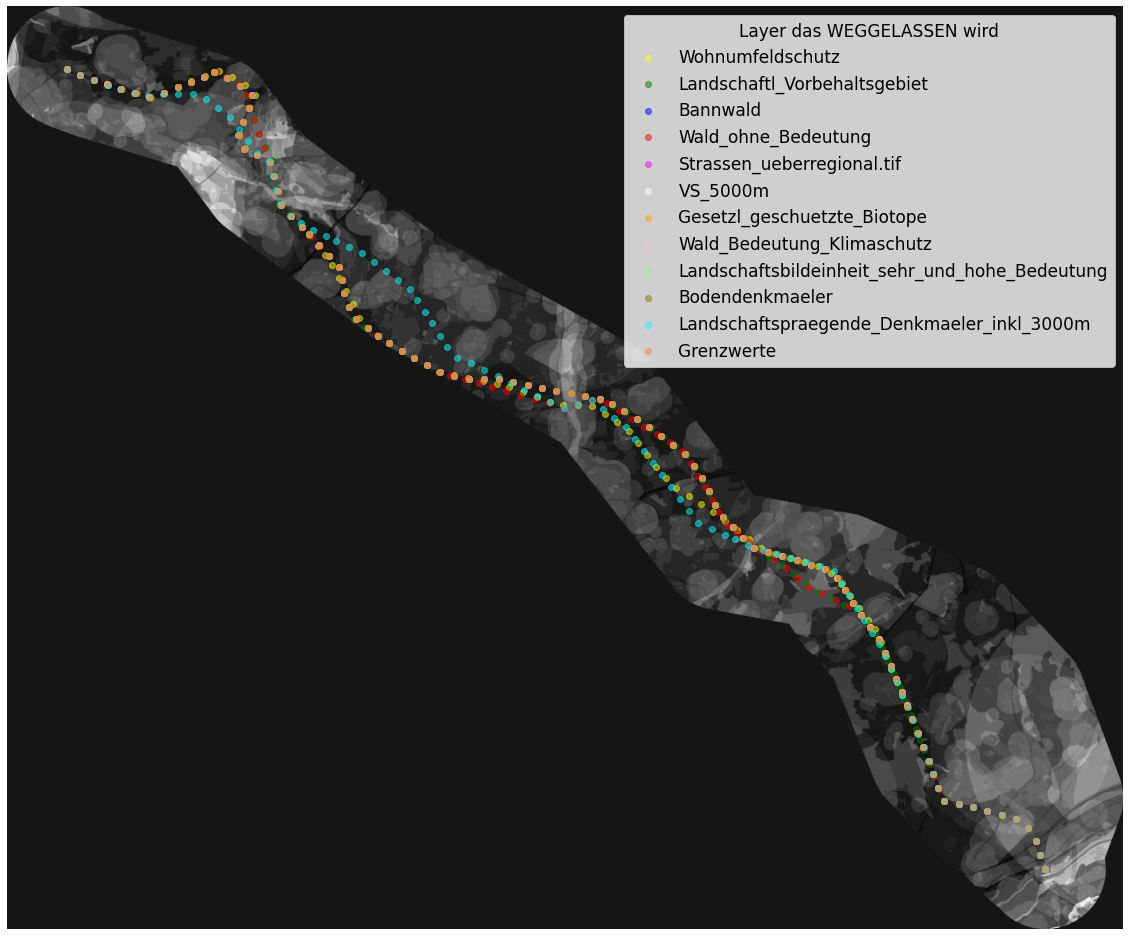

In [88]:
plt.figure(figsize=(20,20))
plt.imshow(disp_inst)
my_cols = ["yellow", "green", "blue", "red", "magenta", "white", "orange", "pink", "lightgreen", "olive", "cyan", "coral", "violet"]
plt.gray()
for j, path in enumerate(path_list):
    if csvs[j][-5]=="0":
        new_label = "_".join((csvs[j]).split("_")[4:-1])
        plt.scatter(path[:,0], path[:,1], label=new_label, alpha=0.5, color=my_cols[int(j/3)])
plt.rcParams['legend.title_fontsize'] = 17
plt.legend(fontsize=17, title="Layer das WEGGELASSEN wird")

plt.axis("off")
plt.savefig("../../figure/de_layer_sensitivity.png", bbox_inches=0, )
plt.show()

## Layer-wise sensitivity with tuples

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(disp_inst)
my_cols = ["yellow", "green", "blue", "red", "magenta", "white", "orange", "pink", "lightgreen", "olive", "cyan", "coral", "violet"]
plt.gray()
for j, path in enumerate(path_list):
    # new_label = " and ".join((csvs[j]).split("-"))
    plt.scatter(path[:,0], path[:,1], label = csvs[j]) # , label=new_label, alpha=0.5, color=my_cols[int(j/3)])
# plt.rcParams['legend.title_fontsize'] = 17
# plt.legend(fontsize=17, title="Layer das WEGGELASSEN wird")

plt.axis("off")
plt.legend()
# plt.savefig("../../figure/de_layer_sensitivity.png", bbox_inches=0, )
plt.show()

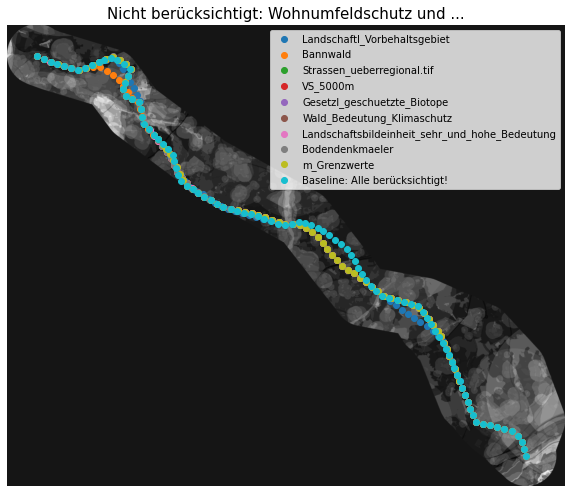

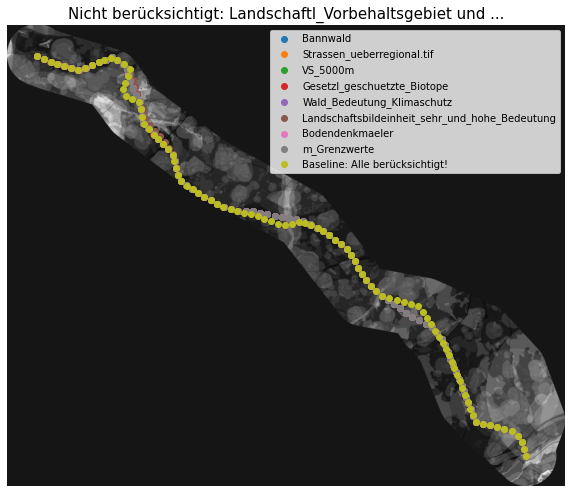

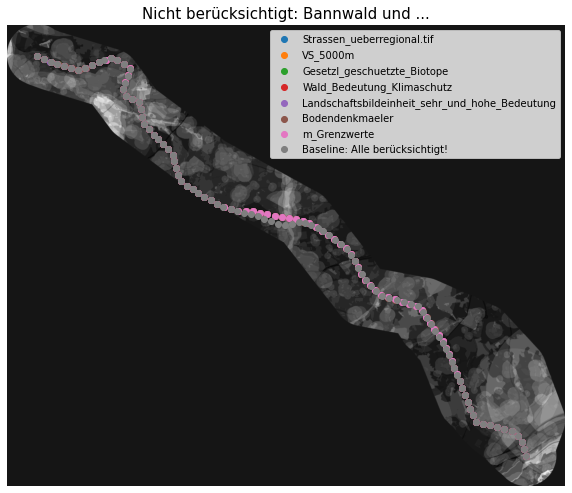

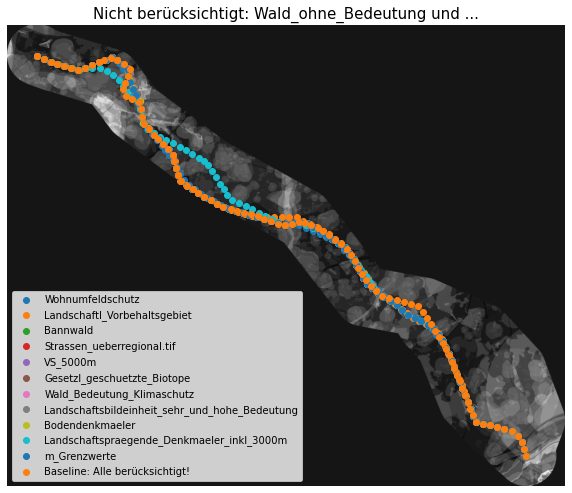

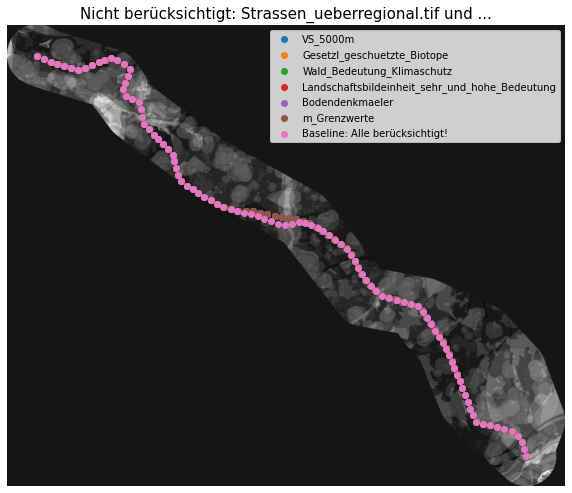

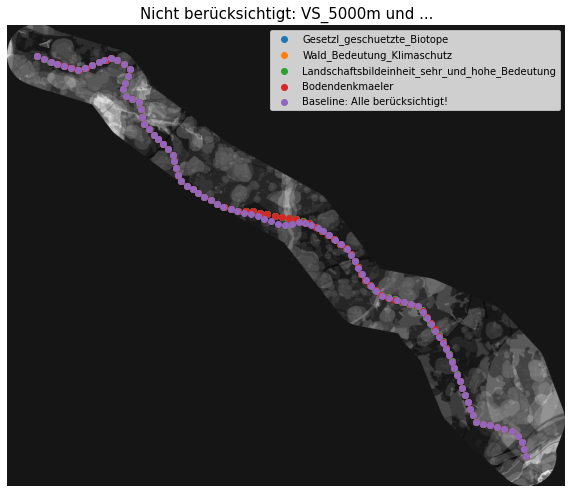

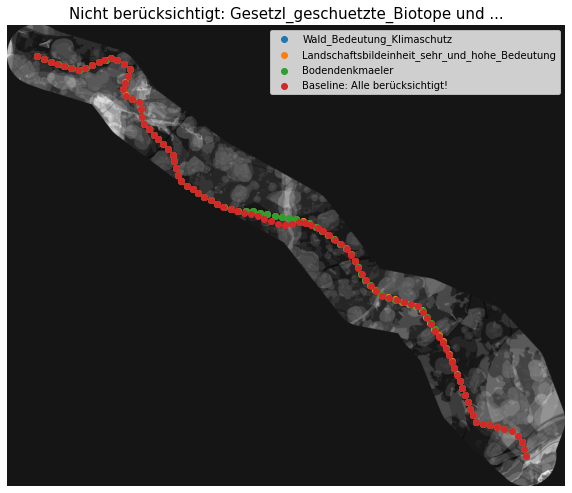

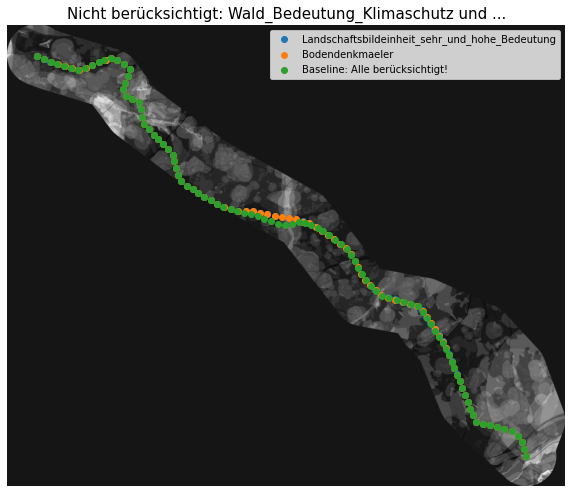

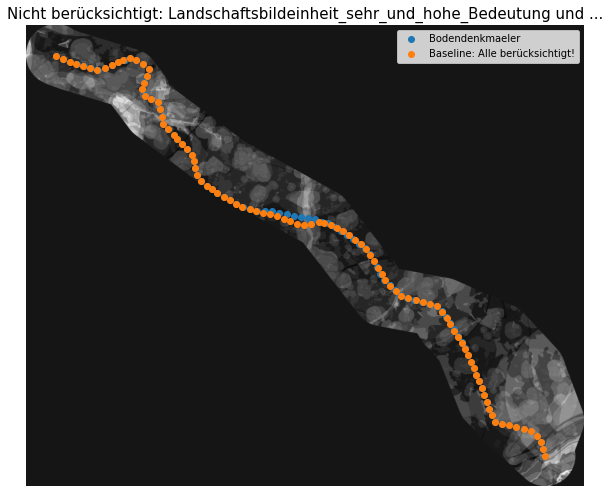

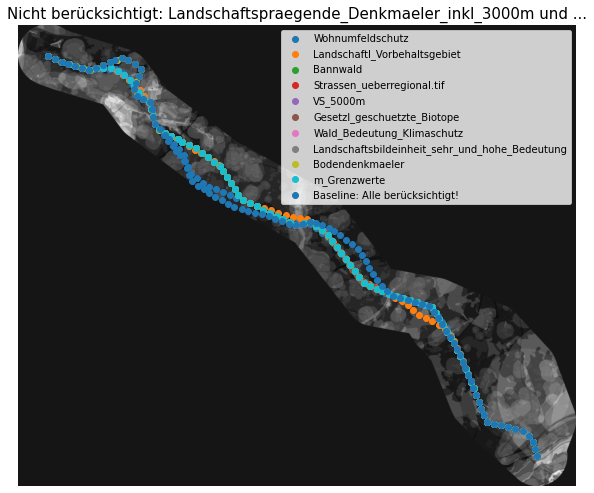

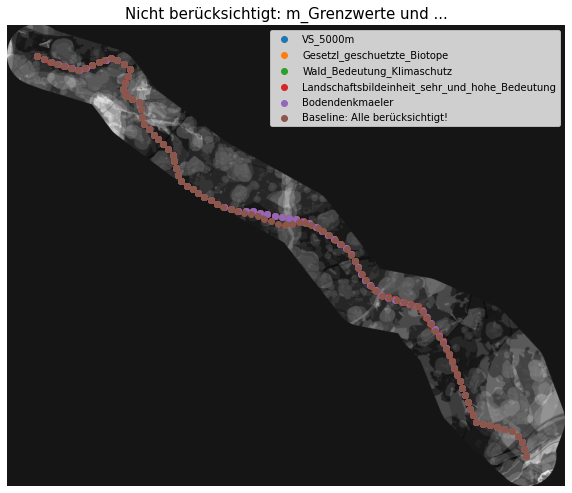

In [267]:
uni_layers = np.unique([csv.split("-")[1]  for csv in csvs if not "baseline" in csv])
for layer in uni_layers:
    plt.figure(figsize=(10,10))
    plt.imshow(disp_inst)
    for path, name in zip(path_list, csvs):
        if "baseline" in name:
            plt.scatter(path[:,0], path[:,1], label="Baseline: Alle berücksichtigt!")
            continue
        layer1, layer2 = (name.split("-")[1], name.split("-")[2])
        if layer1 == layer:
            plt.scatter(path[:,0], path[:,1], label=layer2[7:-4])
        elif layer2==layer:
            plt.scatter(path[:,0], path[:,1], label=layer1[7:-4])
    plt.title("Nicht berücksichtigt: "+layer[7:]+" und ...", fontsize=15)
    plt.legend()
    plt.axis("off")
    plt.savefig("../../outputs/de_presentation/"+layer[7:]+"_left_out.png")
    plt.show()